In [1]:
import numpy as np, pandas as pd, math
from sklearn.model_selection import LeaveOneOut
import matplotlib, matplotlib.pyplot as plt

In [2]:
def f_measure(conf):
    n = len(conf)
    cols = np.sum(conf, axis = 0)
    rows = np.sum(conf, axis = 1)
    precisions = np.array([conf[i][i] / cols[i] if (cols[i] != 0) else 0 for i in range(n)])
    recalls = np.array([conf[i][i] / rows[i] if (rows[i] != 0) else 0 for i in range(n)])
    fs = np.zeros(n)
    for i in range(n):
        if precisions[i] + recalls[i] == 0:
            fs[i] = 0
        else:
            fs[i] = 2 * precisions[i] * recalls[i] / (precisions[i] + recalls[i])
    return np.sum(fs * rows / np.sum(rows))

In [3]:
raw_data = np.loadtxt("students.csv",delimiter = ',', skiprows=1)
y = pd.get_dummies(raw_data[:,-1]).to_numpy()
X = np.delete(raw_data, -1, axis=1)
means = X.mean(axis = 0)
devs = X.std(axis=0)
X = (X - means) / devs
loo = LeaveOneOut()

In [4]:
def manhattan(x, y):
    return sum(abs(x - y))

def euclidean(x, y):
    return np.sqrt(sum((x - y) * (x - y)))

def chebyshev(x, y):
    return max(abs(x - y))

dst = {"manhattan": manhattan, "euclidean": euclidean, "chebyshev": chebyshev}
kernel = {"uniform": lambda x: 1 / 2 if -1 <= x <= 1 else 0,
               "triangular": lambda x: max(1 - abs(x), 0),
               "epanechnikov": lambda x: max(3 / 4 * (1 - x ** 2), 0),
               "quartic": lambda x: max(15 / 16 * (1 - x ** 2) ** 2, 0),
               "tricube": lambda x: max(70 / 81 * (1 - abs(x) ** 3) ** 3, 0),
               "triweight": lambda x: max(0, 35 / 32 * (1 - x ** 2) ** 3),
               "gaussian": lambda x: math.exp(- x ** 2 / 2) / math.sqrt(2 * math.pi),
               "cosine": lambda x: max(0, (math.pi / 4) * math.cos(math.pi * x / 2)),
               "logistic": lambda x: 1 / (2 + math.exp(x) + math.exp(-x)),
               "sigmoid": lambda x: 2 / (math.pi * (math.exp(x) + math.exp(-x)))}

In [5]:
def evaluate(kernel_cur, distance_cur, param, fixed):
    confusion_matrix = np.zeros((5,5))
    if fixed:
        d = param
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test=  y[train_index], y[test_index]
        if not fixed:
            d = sorted([distance_cur(X_test[0], x) for x in X_train])[param]          
        a = np.array([kernel_cur(distance_cur(x, X_test[0]) / d) for x in X_train]).reshape(402,1)
        if sum(a) == 0:
            res = sum(y_train) / np.sum(y_train)
        else:
            res = a * y_train / sum(a)
        prediction = np.argmax(sum(res))
        true_value = np.argmax(y_test)
        confusion_matrix[true_value][prediction] += 1
    return confusion_matrix

In [6]:
max_quality = 0
for dist in list(dst.values()):
    for kern in list(kernel.values()):
        for k in range(1,15):
            quality = f_measure(evaluate(kern, dist, k, False))
            if quality > max_quality:
                best_params = [dist, kern, k, False]
                max_quality = quality
        for h in np.arange(1,10):
            quality = f_measure(evaluate(kern, dist, h, True))
            if quality > max_quality:
                best_params = [dist, kern, h, True]
                max_quality = quality

In [7]:
best_dist, best_kernel, best_k, best_mode = best_params
quality = np.zeros(15)
quality_fixed = list()
for k in range(1,15):
    quality[k] = f_measure(evaluate(best_kernel, best_dist, k, False))
for h in np.arange(1, 10, 0.2):
    quality_fixed.append(f_measure(evaluate(best_kernel, best_dist, h, True)))

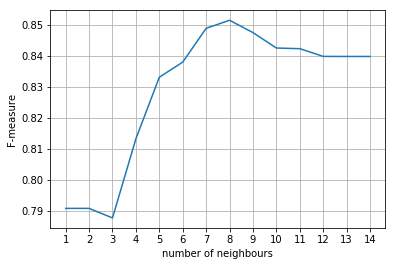

In [8]:
t = np.arange(1, 15)
fig, ax = plt.subplots()
ax.plot(t, quality[1:])
ax.set(xlabel='number of neighbours', ylabel='F-measure', xticks=np.arange(1,15))
ax.grid()
plt.show()

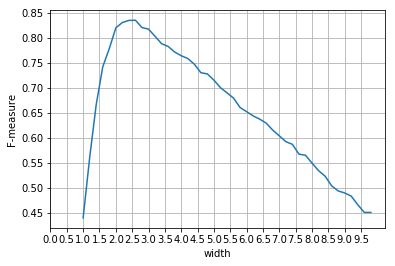

In [9]:
t = np.arange(1,10,0.2)
fig, ax = plt.subplots()
ax.plot(t, quality_fixed)
ax.set(xlabel='width', ylabel='F-measure', xticks=np.arange(0,10,0.5))
ax.grid()
plt.show()

In [11]:
print("best distance is " + list(dst.keys())[list(dst.values()).index(best_dist)])
print("best kernel is " + list(kernel.keys())[list(kernel.values()).index(best_kernel)])
print("best fixed width is " + "%0.1f" % list(t)[np.argmax(quality_fixed)])
print("best kth neighbour is " + str(np.arange(0,15)[np.argmax(quality)]))

best distance is manhattan
best kernel is epanechnikov
best fixed width is 2.6
best kth neighbour is 8
